# Structural virality replication
Date: 1/27/2021

Author: Matthew Sun

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
import datetime
from collections import defaultdict

import trecs
from trecs.models import BassModel
from trecs.random import SocialGraphGenerator

# custom utilities
from graph_utils import (
    calc_avg_degree, 
    implied_beta, 
    scale_free_graph, 
    setup_experiment,
    popularity,
    prob_large_cascade,
    mean_virality,
    std_virality,
    sem_virality,
    size_virality_corr,
    pearsonr_ci
)

from create_graphs import (
    destringify_r,
    destringify_alpha
)

# Helper methods
These methods aid in graphing and loading results from output directories.

In [2]:
def extract_alpha_rs(results_dict):
    """ Result the alpha and rs for the results dictionary.
    """
    alpha_set = set()
    r_set = set()
    for alpha, r in results_dict.keys():
        alpha_set.add(alpha)
        r_set.add(r)
    return sorted(list(alpha_set)), sorted(list(r_set))

In [3]:
# graphing
colors=['red', 'orange', 'green', 'blue', 'purple']

In [4]:
def plot_popularity_chance(results, alphas, rs):
    popularity_chance = {} # map from alpha to list, where each element corresponds to one R value
    for i, alpha in enumerate(alphas):
        popularity_chance[alpha] = [prob_large_cascade(results[(alpha, r)]["size"]) * 100 for r in rs]
        plt.plot(rs, popularity_chance[alpha], label=f"alpha={alpha}", color=colors[i])
    leg = plt.legend()
    plt.xlabel("r")
    plt.ylabel("Probability of popularity (%)")

In [5]:
def plot_avg_virality(results, alphas, rs, pop_mask=False, sd_mult=0.0):
    avg_virality = defaultdict(list) # map from alpha to list, where each element corresponds to one R value
    sd_virality = defaultdict(list)
    for i, alpha in enumerate(alphas):
        for r in rs:
            mask = results[(alpha, r)]["size"] >= 100 if pop_mask else None            
            # restrict graph to popular cascades
            avg_virality[alpha].append(mean_virality(results[(alpha, r)]["virality"], popular_mask=mask))
            if sd_mult > 0:
                sd_virality[alpha].append(sem_virality(results[(alpha, r)]["virality"], popular_mask=mask))
        line = plt.plot(rs, avg_virality[alpha], label=f"alpha={alpha}", color=colors[i])
        line_color = line[0].get_color()
        if sd_mult > 0:
            low = np.array(avg_virality[alpha]) - np.array(sd_virality[alpha])
            high = np.array(avg_virality[alpha]) + np.array(sd_virality[alpha])
            plt.fill_between(rs, low, high, color = line_color, alpha=0.3)
    plt.legend()
    plt.xlabel("r")
    plt.ylabel("Mean structural virality")

### 1M node experiments

In [8]:
# replace with the experimental output directory in your experiment!
exp_dirs = ["exps"]

agg_results = defaultdict(lambda: defaultdict(list)) # holds results for entire simulation
virality_multiplier = 2 # 2/25/2021: the structural virality measure in t-recs is 1/2 what it should be 

# process experimental results for each graph and add to aggregate results
for exp_dir in exp_dirs:
    for (root,dirs,files) in os.walk(exp_dir, topdown=True): 
        for f in files:
            if f == "sim_result.pkl":
                folders = os.path.normpath(root).split(os.path.sep)
                alpha, r = destringify_alpha(folders[-3]), destringify_r(folders[-2])
                result = pkl.load(open(os.path.join(root, f), "rb"))
                agg_results[(alpha, r)]["size"].append(result["size"])
                agg_results[(alpha, r)]["virality"].append(virality_multiplier * result["virality"])
            elif f == "merged_results.pkl":
                result = pkl.load(open(os.path.join(root, f), "rb"))
                for k in result.keys():
                    agg_results[k]["size"].append(result[k]["size"])
                    agg_results[k]["virality"].append(virality_multiplier * result[k]["virality"])
            
for alpha_r in agg_results.keys():
    agg_results[alpha_r]["size"] = np.concatenate(agg_results[alpha_r]["size"])
    agg_results[alpha_r]["virality"] = np.concatenate(agg_results[alpha_r]["virality"])

In [9]:
alphas, rs = extract_alpha_rs(agg_results)

In [10]:
# for each level of alpha and r, what are the #s of trials we observe?
# for alpha in alphas:
#     for r in rs:
#         total_trials = agg_results[(alpha, r)]['size'].shape[0]
#         print(f"Number of trials present for alpha={alpha}, r={r}: {total_trials}")
#         num_large = len(np.where(agg_results[(alpha, r)]["size"] > 100)[0])
#         print(f"Trials that resulted in large cascade: {num_large}")
#         print()

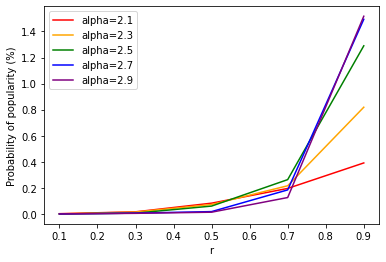

In [11]:
plot_popularity_chance(agg_results, alphas, rs)

/mnt/c/Users/matth/pton-research/recsys/exp-temp/t-recs-experiments/structural_virality/graph_utils.py:96: RuntimeWarning: Mean of empty slice.
  return popular_viralitys[popular_viralitys > -1].mean()
/home/mattsun/anaconda3/envs/trecs_exp/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


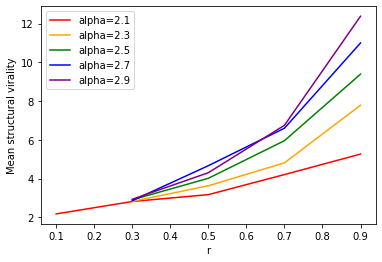

In [12]:
plot_avg_virality(agg_results, alphas, rs, pop_mask=True)

In [13]:
# alpha = 2.3, r = 0.5 setting
size_virality_corr(agg_results[(2.3, 0.5)]["size"], agg_results[(2.3, 0.5)]["virality"], only_popular=True, pop_threshold=100)

Number of observations: 119


0.08558092125079826